# Predict `Subject Age`

In [1]:
%matplotlib inline

In [18]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
import time
from pathlib import Path

In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
phenotype = 'Subject Age'

In [7]:
#load data
with open("aging-cytof-data.obj", "rb") as f:
    allData = pickle.load(f)
samples = allData["samples"]
cyto_data = allData['expr_list']
markers = allData["marker_names"]

print(f'Dimensions of cyto_data: {cyto_data.shape}')
print(f'Dimensions of samples: {samples.shape}')
print(f'Names of the makers: {markers.values}')

Dimensions of cyto_data: (260, 45000, 27, 1)
Dimensions of samples: (260, 47)
Names of the makers: ['CELL_LENGTH' 'DEAD' 'CD19' 'CD4' 'CD8' 'IGD' 'CD85J' 'CD16' 'CD3' 'CD38'
 'CD27' 'CD14' 'CD94' 'CCR7' 'CD45RA' 'CD20' 'CD127' 'CD33' 'CD28' 'CD24'
 'CD161' 'TCRGD' 'CD56' 'HLADR' 'CD25' 'DNA1' 'DNA2']


count    260.000000
mean      68.303846
std       15.169696
min       41.000000
25%       55.000000
50%       69.000000
75%       82.000000
max       90.000000
Name: Subject Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

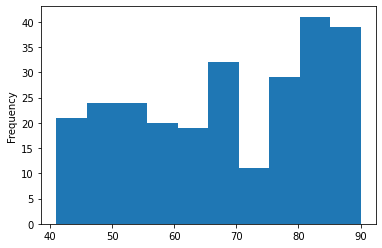

In [8]:
print(samples[phenotype].describe())
samples[phenotype].plot.hist()

In [9]:
##### Step 3: split train, validation and test######
x = []
y = []
for i, row in samples.iterrows():
    x.append(cyto_data[i])
    y.append(row[phenotype])
age_range = max(y) - min(y)
x = np.asarray(x)
y_raw = np.asarray(y)
age_min = min(y_raw)
age_max = max(y_raw)
age_range = age_max - age_min
y = (y_raw - age_min) / age_range

x_train, x_valid, y_train, y_valid = train_test_split(x, y)

In [42]:
aging_model = Sequential([
    Input(shape=x[0].shape),
    Conv2D(3, kernel_size = (1, x.shape[2]), activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(3, kernel_size = (1,1), activation=None),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size = (x.shape[1], 1)),
    Flatten(),
    Dense(3, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dense(1, activation=None),
#     BatchNormalization(),
#     Activation('sigmoid'),
])
aging_model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])
aging_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 45000, 1, 3)       84        
_________________________________________________________________
batch_normalization_9 (Batch (None, 45000, 1, 3)       12        
_________________________________________________________________
activation_9 (Activation)    (None, 45000, 1, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45000, 1, 3)       12        
_________________________________________________________________
batch_normalization_10 (Batc (None, 45000, 1, 3)       12        
_________________________________________________________________
activation_10 (Activation)   (None, 45000, 1, 3)       0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 1, 1, 3)          

In [43]:
model = aging_model
model_store = Path('Result/saved_weights.hdf5')

# save the best performing model
checkpointer = ModelCheckpoint(filepath=model_store, 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=200, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

Epoch 1/200
4/4 [==============================] - 2s 335ms/step - loss: 0.6679 - mean_absolute_error: 0.6679 - val_loss: 1.3525 - val_mean_absolute_error: 1.3525
Epoch 2/200
4/4 [==============================] - 1s 144ms/step - loss: 0.6770 - mean_absolute_error: 0.6770 - val_loss: 1.3687 - val_mean_absolute_error: 1.3687
Epoch 3/200
4/4 [==============================] - 1s 145ms/step - loss: 0.6478 - mean_absolute_error: 0.6478 - val_loss: 1.3824 - val_mean_absolute_error: 1.3824
Epoch 4/200
4/4 [==============================] - 1s 146ms/step - loss: 0.6065 - mean_absolute_error: 0.6065 - val_loss: 1.3879 - val_mean_absolute_error: 1.3879
Epoch 5/200
4/4 [==============================] - 1s 145ms/step - loss: 0.5900 - mean_absolute_error: 0.5900 - val_loss: 1.3930 - val_mean_absolute_error: 1.3930
Epoch 6/200
4/4 [==============================] - 1s 153ms/step - loss: 0.5556 - mean_absolute_error: 0.5556 - val_loss: 1.3957 - val_mean_absolute_error: 1.3957
Epoch 7/200
4/4 [=====

In [44]:
rt

114.72114753723145

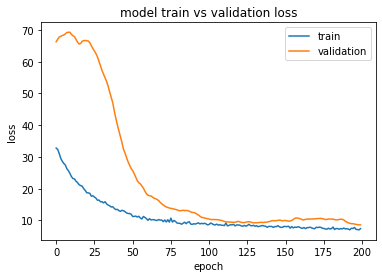

In [45]:
##### Step 6: plot train and validation loss #####
history = model.history
plt.plot(age_range*pd.Series(history.history['mean_absolute_error']))
plt.plot(age_range*pd.Series(history.history['val_mean_absolute_error']))
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

count    65.000000
mean     -0.808752
std      11.703437
min     -29.593882
25%      -7.049193
50%       1.014911
75%       4.326317
max      35.011182
dtype: float64


<AxesSubplot:ylabel='Frequency'>

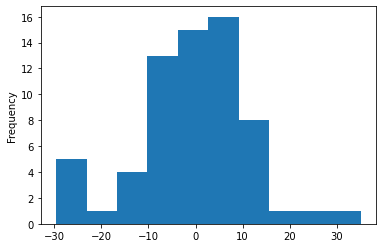

In [46]:
#### Step 7: test the final model #####
# final_model = model
# load final model
final_model = load_model(model_store)
x_test = x_valid
y_test = y_valid

# generate ROC and AUC
y_scores = final_model.predict([x_test])
y_scores = y_scores.reshape(y_scores.shape[0])
errors = age_range * (pd.Series(y_scores)-pd.Series(y_valid))
print(errors.describe())
errors.plot.hist()